In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
results_folder = 'results'
data_types = ['WikiText103', 'tweets']
algorithms = ['FedAVG', 'LICCHAVI_L1', 'LICCHAVI_L2']

hyperparameters_filename = 'hyperparams.pickle'
metrics_filename = 'metrics.pickle'

In [3]:
def collect():
    results = {}

    for data_type in data_types:
        results[data_type] = {}
        for algorithm in os.listdir(os.path.join(results_folder, data_type)):
            results[data_type][algorithm] = []
            path = os.path.join(results_folder, data_type, algorithm)
            for folder in os.listdir(path):
                hyperparameters_file = os.path.join(path, folder, hyperparameters_filename)
                metrics_file = os.path.join(path, folder, metrics_filename)

                with open(hyperparameters_file, 'rb') as f:
                    hyperparameters = pickle.load(f)
                for params in ['DATA_PARAMETERS', 'MODEL_PARAMETERS', 'TRAINING_PARAMETERS', 'FEDERATED_ARGS']:
                    params = hyperparameters.pop(params)
                    hyperparameters.update(params)

                with open(metrics_file, 'rb') as f:
                    metrics = pickle.load(f)

                # performs the average per epoch
                if 'attack_perplexity' in metrics.keys():
                    att_perp = []
                    model_att_perp = []

                avg_perp, avg_f1, avg_f3 = [], [], []
                model_perp, model_f1, model_f3,  = [],[],[]
                N = hyperparameters['num_training_nodes'] - hyperparameters['num_byzantine']

                for _, values in metrics.items():
                    avg_perp.append(np.mean([values[f'perplexity_{j}'] for j in range(1,N+1)]))
                    avg_f1.append(np.mean([values[f'f1_recall_{j}'] for j in range(1,N+1)]))
                    avg_f3.append(np.mean([values[f'f3_recall_{j}'] for j in range(1,N+1)]))
                    model_perp.append(values['perplexity'])
                    model_f1.append(values['f1_recall'])
                    model_f3.append(values['f3_recall'])
                    if 'attack_perplexity' in metrics.keys():
                        att_perp.append([values[f'attack_perplexity_{j}'] for j in range(1,N+1)])
                        model_att_perp.append(values['attack_perplexity'])
                # selects the best epoch for all metrics
                res = {
                    'min_perpl' : np.min(avg_perp),
                    'max_f1' : np.max(avg_f1),
                    'max_f3' : np.max(avg_f3),
                    'epoch_min_perpl' : np.argmin(avg_perp),
                    'epoch_max_f1' : np.argmax(avg_f1),
                    'epoch_max_f3' : np.argmax(avg_f3),

                    'model_min_perpl' : np.min(model_perp),
                    'model_max_f1' : np.max(model_f1),
                    'model_max_f3' : np.max(model_f3),
                    'model_epoch_min_perpl' : np.argmin(model_perp),
                    'model_epoch_max_f1' : np.argmax(model_f1),
                    'model_epoch_max_f3' : np.argmax(model_f3)
                }



                hyperparameters.update(res)
                results[data_type][algorithm].append(hyperparameters)
    return results

In [4]:
parameters = {
    'FedAVG' : ['node_model_lr', 'C', 'batch_size', 'num_epochs', 'gamma'],
    'LICCHAVI_L1' : ['node_model_lr', 'general_model_lr', 'batch_size','num_epochs'],
    'LICCHAVI_L2' : ['node_model_lr', 'general_model_lr', 'batch_size','num_epochs']
}

In [5]:
def display(data, algorithm, metric, nodes, parameters):
    if nodes:
        l = ['max_f3', 'epoch_max_f3','max_f1','epoch_max_f1','min_perpl','epoch_min_perpl']
    else:
        l = ['model_max_f3', 'model_epoch_max_f3', 'model_max_f1', 'model_epoch_max_f1','model_min_perpl','model_epoch_min_perpl']
    return pd.DataFrame(
        results[data][algorithm]).sort_values(
            metric
        )[parameters+l].set_index(parameters)

## TWEETS

In [6]:
results = collect()

### FedAVG

In [327]:
display('tweets','FedAVG','max_f3',True,parameters['FedAVG'])

max_f3  epoch_max_f3  \
node_model_lr C batch_size num_epochs gamma                             
0.00100       1 32         1          0.00001  0.331330             0   
                           3          0.00001  0.331330             0   
                           2          0.00001  0.331330             0   
0.00001       1 32         1          0.00001  0.332306             5   
                           2          0.00001  0.332908             5   
                                      0.00001  0.332919             5   
                16         2          0.00001  0.333085             5   
                8          2          0.00001  0.333392             5   
                32         3          0.00001  0.333486             5   
0.00010       1 32         1          0.00001  0.333748             5   
                           3          0.00001  0.334134             4   
                           2          0.00001  0.334224             3   

                                                 max_f1  epoch_max_f1  \
node_model_lr C batch_size num_epochs gamma                             
0.00100       1 32         1          0.00001  0.220690             0   
                           3          0.00001  0.220690             0   
                           2          0.00001  0.220690             0   
0.00001       1 32         1          0.00001  0.221656             5   
                           2          0.00001  0.223022             5   
                                      0.00001  0.222922             5   
                16         2          0.00001  0.222988             5   
                8          2          0.00001  0.223403             5   
                32         3          0.00001  0.223082             5   
0.00010       1 32         1          0.00001  0.223631             3   
                           3          0.00001  0.223841             3   
                           2          0.00001  0.224382             3   

                                                min_perpl  epoch_min_perpl  
node_model_lr C batch_size num_epochs gamma                                 
0.00100       1 32         1          0.00001  159.634948                0  
                           3          0.00001  159.634948                0  
                           2          0.00001  159.634948                0  
0.00001       1 32         1          0.00001  158.567416                5  
                           2          0.00001  157.718701                5  
                                      0.00001  157.744139                5  
                16         2          0.00001  157.467110                4  
                8          2          0.00001  158.013549                2  
                32         3          0.00001  157.226239                5  
0.00010       1 32         1          0.00001  157.845368                2  
                           3          0.00001  159.634948                0  
                           2          0.00001  159.331223                1

In [328]:
display('tweets','FedAVG','model_max_f3',False,parameters['FedAVG'])

model_max_f3  \
node_model_lr C batch_size num_epochs gamma                   
0.00001       1 8          2          0.00001      0.455443   
0.00100       1 32         1          0.00001      0.455550   
                           3          0.00001      0.455550   
0.00010       1 32         3          0.00001      0.455550   
0.00100       1 32         2          0.00001      0.455550   
0.00001       1 16         2          0.00001      0.455966   
0.00010       1 32         2          0.00001      0.456533   
0.00001       1 32         1          0.00001      0.456987   
0.00010       1 32         1          0.00001      0.457063   
0.00001       1 32         2          0.00001      0.457517   
                           3          0.00001      0.457668   
                           2          0.00001      0.457668   

                                               model_epoch_max_f3  \
node_model_lr C batch_size num_epochs gamma                         
0.00001       1 8          2          0.00001                   2   
0.00100       1 32         1          0.00001                   0   
                           3          0.00001                   0   
0.00010       1 32         3          0.00001                   0   
0.00100       1 32         2          0.00001                   0   
0.00001       1 16         2          0.00001                   3   
0.00010       1 32         2          0.00001                   1   
0.00001       1 32         1          0.00001                   5   
0.00010       1 32         1          0.00001                   1   
0.00001       1 32         2          0.00001                   5   
                           3          0.00001                   3   
                           2          0.00001                   5   

                                               model_max_f1  \
node_model_lr C batch_size num_epochs gamma                   
0.00001       1 8          2          0.00001      0.346666   
0.00100       1 32         1          0.00001      0.345994   
                           3          0.00001      0.345994   
0.00010       1 32         3          0.00001      0.346675   
0.00100       1 32         2          0.00001      0.345994   
0.00001       1 16         2          0.00001      0.345843   
0.00010       1 32         2          0.00001      0.346902   
0.00001       1 32         1          0.00001      0.347053   
0.00010       1 32         1          0.00001      0.346599   
0.00001       1 32         2          0.00001      0.347431   
                           3          0.00001      0.347204   
                           2          0.00001      0.347356   

                                               model_epoch_max_f1  \
node_model_lr C batch_size num_epochs gamma                         
0.00001       1 8          2          0.00001                   3   
0.00100       1 32         1          0.00001                   0   
                           3          0.00001                   0   
0.00010       1 32         3          0.00001                   1   
0.00100       1 32         2          0.00001                   0   
0.00001       1 16         2          0.00001                   3   
0.00010       1 32         2          0.00001                   1   
0.00001       1 32         1          0.00001                   4   
0.00010       1 32         1          0.00001                   1   
0.00001       1 32         2          0.00001                   3   
                           3          0.00001                   4   
                           2          0.00001                   3   

                                               model_min_perpl  \
node_model_lr C batch_size num_epochs gamma                      
0.00001       1 8          2          0.00001        57.941335   
0.00100       1 32         1          0.00001        57.600457   
                           3          0.00001        57.600457   
0.00010       1 3

### LICCHAVI_L1

In [329]:
display('tweets','LICCHAVI_L1','max_f3',True,parameters['LICCHAVI_L1'])

max_f3  epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00010          32         1           0.331396             5   
              0.00001          32         1           0.331406             5   
              0.00100          32         1           0.331481             5   
0.00010       0.00010          32         1           0.332054             5   
              0.00100          32         1           0.332114             5   
              0.00001          32         1           0.332256             5   
0.00100       0.00100          32         1           0.334171             5   
              0.00010          32         1           0.336200             5   
              0.00001          32         1           0.336212             5   
              0.00100          32         2           0.337885             5   
                               16         1           0.338052             5   
                               32         3           0.338841             5   
                               8          1           0.339986             5   

                                                        max_f1  epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00010          32         1           0.220769             5   
              0.00001          32         1           0.220704             5   
              0.00100          32         1           0.220804             4   
0.00010       0.00010          32         1           0.221370             5   
              0.00100          32         1           0.221477             5   
              0.00001          32         1           0.221289             5   
0.00100       0.00100          32         1           0.223777             5   
              0.00010          32         1           0.223616             5   
              0.00001          32         1           0.223665             5   
              0.00100          32         2           0.226865             5   
                               16         1           0.227071             5   
                               32         3           0.228271             5   
                               8          1           0.228344             5   

                                                       min_perpl  \
node_model_lr general_model_lr batch_size num_epochs               
0.00001       0.00010          32         1           159.462233   
              0.00001          32         1           159.482477   
              0.00100          32         1           159.475359   
0.00010       0.00010          32         1           158.331611   
              0.00100          32         1           158.239311   
              0.00001          32         1           158.338629   
0.00100       0.00100          32         1           153.173595   
              0.00010          32         1           153.025045   
              0.00001          32         1           153.047489   
              0.00100          32         2           148.719124   
                               16         1           148.485409   
                               32         3           145.419204   
                               8          1           143.090109   

                                                      epoch_min_perpl  
node_model_lr general_model_lr batch_size num_epochs                   
0.00001       0.00010          32         1                         5  
              0.00001          32         1                         5  
              0.00100          32         1                         5  
0.00010       0.00010          32         1                         5  
              0.00100          32         1                         5  
              0.00001          32         1                         5  
0.00100       0.00100          32         1              

In [330]:
display('tweets','LICCHAVI_L1','model_max_f3',False,parameters['LICCHAVI_L1'])

model_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00100       0.00100          16         1               0.454396   
                               8          1               0.454620   
0.00010       0.00010          32         1               0.455550   
0.00100       0.00010          32         1               0.455550   
0.00001       0.00001          32         1               0.455550   
0.00010       0.00001          32         1               0.455550   
0.00100       0.00001          32         1               0.455550   
              0.00100          32         1               0.455625   
0.00001       0.00010          32         1               0.455625   
              0.00100          32         1               0.455701   
0.00100       0.00100          32         3               0.455928   
                                          2               0.455928   
0.00010       0.00100          32         1               0.456155   

                                                      model_epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00100       0.00100          16         1                            1   
                               8          1                            4   
0.00010       0.00010          32         1                            0   
0.00100       0.00010          32         1                            0   
0.00001       0.00001          32         1                            0   
0.00010       0.00001          32         1                            0   
0.00100       0.00001          32         1                            0   
              0.00100          32         1                            2   
0.00001       0.00010          32         1                            2   
              0.00100          32         1                            1   
0.00100       0.00100          32         3                            5   
                                          2                            2   
0.00010       0.00100          32         1                            3   

                                                      model_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00100       0.00100          16         1               0.346142   
                               8          1               0.345694   
0.00010       0.00010          32         1               0.346221   
0.00100       0.00010          32         1               0.346069   
0.00001       0.00001          32         1               0.345994   
0.00010       0.00001          32         1               0.345994   
0.00100       0.00001          32         1               0.345994   
              0.00100          32         1               0.346069   
0.00001       0.00010          32         1               0.346145   
              0.00100          32         1               0.346675   
0.00100       0.00100          32         3               0.347204   
                                          2               0.346372   
0.00010       0.00100          32         1               0.347583   

                                                      model_epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00100       0.00100          16         1                            5   
                               8          1                            4   
0.00010       0.00010          32         1                            4   
0.00100       0.00010          32         1                            1   
0.00001       0.00001          32         1                            0   
0.00010       0.00001          32         1                            0   
0.00100       0.00001          32         1                            0   
              0.00100          32         1                            1   
0.00001       0.00010          32         1        

### LICCHAVI_L2

In [331]:
display('tweets','LICCHAVI_L2','max_f3',True,parameters['LICCHAVI_L2'])

max_f3  epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00100          32         1           0.334227             5   
              0.00010          8          1           0.335684             5   
              0.00100          16         1           0.335787             5   
                               8          1           0.336851             5   
0.00010       0.00100          32         1           0.347708             5   
              0.00001          8          1           0.348893             5   
              0.00010          8          1           0.349470             5   
              0.00100          16         1           0.350170             5   
                               8          1           0.352274             5   
0.00100       0.00100          32         1           0.367082             5   
                               16         1           0.371182             5   
                               32         2           0.372160             5   
              0.00001          8          1           0.372462             5   
              0.00010          8          1           0.372874             5   
              0.00100          8          1           0.374509             5   
                               32         3           0.375518             5   

                                                        max_f1  epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00100          32         1           0.223620             5   
              0.00010          8          1           0.224767             5   
              0.00100          16         1           0.224983             5   
                               8          1           0.225793             5   
0.00010       0.00100          32         1           0.234978             5   
              0.00001          8          1           0.235456             5   
              0.00010          8          1           0.235612             5   
              0.00100          16         1           0.235961             5   
                               8          1           0.237791             5   
0.00100       0.00100          32         1           0.249729             5   
                               16         1           0.253079             5   
                               32         2           0.254299             5   
              0.00001          8          1           0.254443             5   
              0.00010          8          1           0.254346             5   
              0.00100          8          1           0.255842             5   
                               32         3           0.255443             5   

                                                       min_perpl  \
node_model_lr general_model_lr batch_size num_epochs               
0.00001       0.00100          32         1           154.820999   
              0.00010          8          1           152.953249   
              0.00100          16         1           152.930213   
                               8          1           150.810839   
0.00010       0.00100          32         1           138.361795   
              0.00001          8          1           137.158752   
              0.00010          8          1           136.714636   
              0.00100          16         1           135.282388   
                               8          1           132.205482   
0.00100       0.00100          32         1           115.408510   
                               16         1           111.301020   
                               32         2           110.393263   
              0.00001          8          1           111.085096   
              0.00010          8          1           110.775781   
              0.00100          8          1           108.404811   
                  

In [332]:
display('tweets','LICCHAVI_L2','model_max_f3',False,parameters['LICCHAVI_L2'])

model_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00010       0.00001          8          1               0.454022   
0.00100       0.00001          8          1               0.454097   
              0.00010          8          1               0.455218   
0.00001       0.00010          8          1               0.455592   
0.00010       0.00010          8          1               0.455592   
0.00001       0.00100          8          1               0.456863   
                               16         1               0.457237   
                               32         1               0.458425   
0.00010       0.00100          16         1               0.459255   
                               8          1               0.459330   
                               32         1               0.460241   
0.00100       0.00100          8          1               0.460377   
                               16         1               0.460452   
                               32         3               0.461829   
                                          1               0.461905   
                                          2               0.462208   

                                                      model_epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00010       0.00001          8          1                            0   
0.00100       0.00001          8          1                            5   
              0.00010          8          1                            5   
0.00001       0.00010          8          1                            5   
0.00010       0.00010          8          1                            5   
0.00001       0.00100          8          1                            1   
                               16         1                            1   
                               32         1                            1   
0.00010       0.00100          16         1                            5   
                               8          1                            5   
                               32         1                            4   
0.00100       0.00100          8          1                            5   
                               16         1                            4   
                               32         3                            5   
                                          1                            5   
                                          2                            5   

                                                      model_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00010       0.00001          8          1               0.344946   
0.00100       0.00001          8          1               0.344946   
              0.00010          8          1               0.345769   
0.00001       0.00010          8          1               0.346068   
0.00010       0.00010          8          1               0.345918   
0.00001       0.00100          8          1               0.347339   
                               16         1               0.347039   
                               32         1               0.348188   
0.00010       0.00100          16         1               0.350254   
                               8          1               0.350404   
                               32         1               0.351441   
0.00100       0.00100          8          1               0.350329   
                               16         1               0.349581   
                               32         3               0.350533   
                                          1               0.350987   
                                          2               0.350836   

                                                      model_epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00010    

# wiki

In [333]:
results = collect()

## FedAVG

In [231]:
display('WikiText103','FedAVG','max_f3',True,parameters['FedAVG'])

KeyError: 'FedAVG'

In [232]:
display('WikiText103','FedAVG','max_f3',False,parameters['FedAVG'])

KeyError: 'FedAVG'

## LICCHAVI_L1

In [233]:
display('WikiText103','LICCHAVI_L1','max_f3',True,parameters['LICCHAVI_L1'])

KeyError: 'LICCHAVI_L1'

In [234]:
display('WikiText103','LICCHAVI_L1','max_f3',False,parameters['LICCHAVI_L1'])

KeyError: 'LICCHAVI_L1'

## LICCHAVI_L2

In [235]:
display('WikiText103','LICCHAVI_L2','max_f3',True,parameters['LICCHAVI_L2'])

KeyError: 'LICCHAVI_L2'

In [236]:
display('WikiText103','LICCHAVI_L2','max_f3',False,parameters['LICCHAVI_L2'])

KeyError: 'LICCHAVI_L2'

## Distribution

1800
59581
4132.544354838709
976


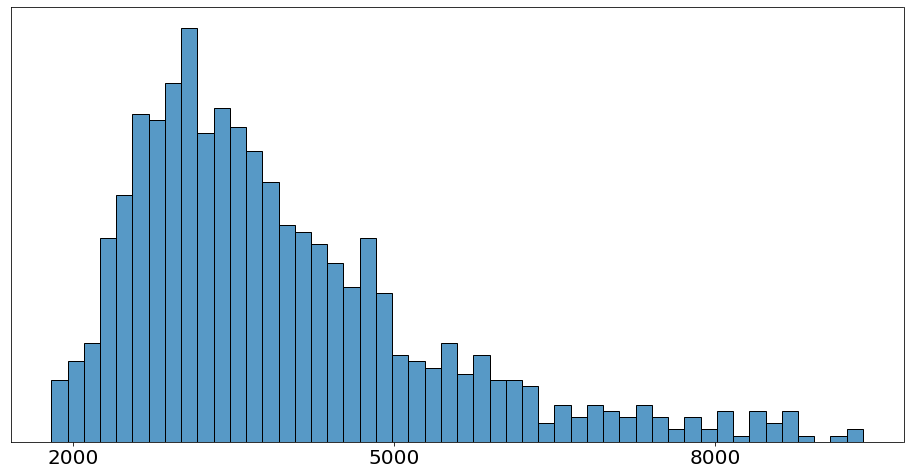

In [782]:
path = os.path.join('nodes_data', 'nodes_data_tweets')
bodies = np.array([int(f.split('_')[2]) for f in os.listdir(path)])
print(min(bodies))
print(max(bodies))
print(np.mean(bodies))
bodies = bodies[bodies<10000]
print(len(bodies))
plt.figure(figsize=(16, 8))
ax = seaborn.histplot(x = bodies, bins = 50, stat = 'count', legend = False)
plt.ylabel(None)
plt.yticks([])
plt.xlabel(None)
plt.xticks([2000, 5000, 8000])
ax.tick_params(labelsize=20)
plt.savefig('dist_tweets.jpg')
plt.show()

10
147
28.738
1000


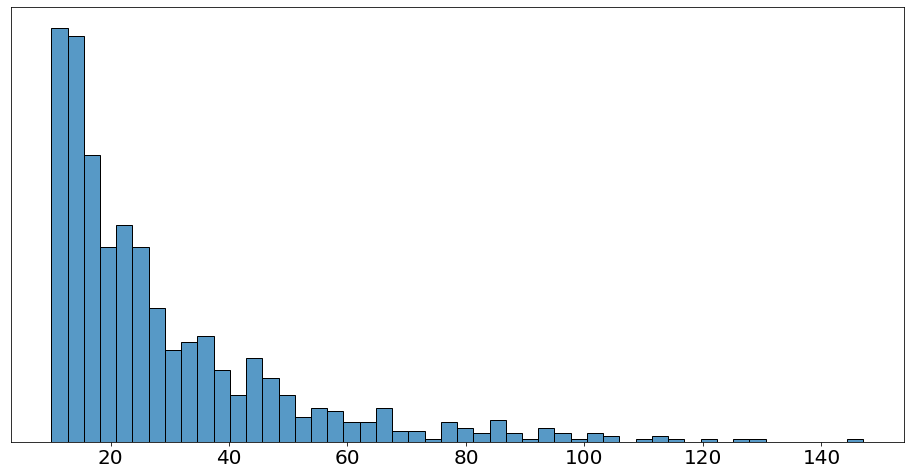

In [783]:
path = os.path.join('nodes_data', 'nodes_data_wiki103')
bodies = np.array([int(f.split('_')[2].split('.')[0]) for f in os.listdir(path)])
print(min(bodies))
print(max(bodies))
print(np.mean(bodies))
bodies = bodies[bodies<10000]
print(len(bodies))
plt.figure(figsize=(16, 8))
ax = seaborn.histplot(x = bodies, bins = 50, stat = 'count', legend = False)
plt.ylabel(None)
plt.yticks([])
plt.xlabel(None)
#plt.xticks([2000, 5000, 8000])
ax.tick_params(labelsize=20)
plt.savefig('dist_wiki.jpg')
plt.show()

# ATTACKS

## Normal Data Poisoning

{ 

   data : {
   
       alg : {
       
           attack : {
               
               num_nodes : {
                   
                   f : {
                       
                       list1 : []
                       
                       list2 : []
                   
                   }
                   
               }
               
           }
       }
   }
}

In [155]:
results_folder = 'attacks_results'

all_metrics = {}

agg = {}
for data in ['tweets']:
    agg[data] = {}
    for algorithm in algorithms:
        agg[data][algorithm] = {}
        path = os.path.join(results_folder, data, algorithm)
        for file in os.listdir(path):
            hyperparams_file = os.path.join(path, file, hyperparameters_filename)
            metrics_file = os.path.join(path, file, metrics_filename)
            
            with open(hyperparams_file, 'rb') as f:
                hyperparams = pickle.load(f)

            with open(metrics_file, 'rb') as f:
                metrics = pickle.load(f)
                
            byz_type = hyperparams['FEDERATED_ARGS']['byzantine_type']
            K = hyperparams['FEDERATED_ARGS']['num_training_nodes']
            f = hyperparams['FEDERATED_ARGS']['num_byzantine']
            f = f/K
            all_metrics[algorithm+'_'+str(f)] = metrics
            
            if byz_type != 'null':
                m = metrics
                nodes_att_perpl = list(pd.DataFrame(metrics).T.filter(regex = r'attack_perplexity_').T.mean())
                nodes_f3_recall = list(pd.DataFrame(metrics).T.filter(regex = r'f3_recall_').T.mean())
                
                model_att_perpl = list(pd.DataFrame(metrics).T['attack_perplexity'])
                model_f3_recall = list(pd.DataFrame(metrics).T['f3_recall'])
                
                if byz_type not in agg[data][algorithm].keys():
                    agg[data][algorithm][byz_type] = {}
                
                if K not in agg[data][algorithm][byz_type].keys():
                    agg[data][algorithm][byz_type][K] = {}
                
                agg[data][algorithm][byz_type][K][f] = {
                    'nodes_att_perpl' : nodes_att_perpl,
                    'nodes_f3_recall' : nodes_f3_recall,
                    'model_att_perpl' : model_att_perpl,
                    'model_f3_recall' : model_f3_recall
                }
                    

            

In [158]:
tmp = list(all_metrics.values())

In [160]:
pd.DataFrame(tmp[0])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
perplexity,57.6005,57.6266,57.5722,57.553,57.5486,57.7848,57.8119,58.2883,58.2491,58.8847,...,59.636,60.6311,61.6844,60.9566,60.6497,60.6039,61.5302,62.5421,62.0318,61.8861
loss,4.06355,4.06401,4.06309,4.06281,4.06272,4.06687,4.06731,4.07558,4.07484,4.08577,...,4.09853,4.11515,4.13242,4.12041,4.11532,4.11452,4.12972,4.14606,4.13781,4.13545
f1_recall,0.345994,0.346599,0.346826,0.346977,0.34728,0.346675,0.346221,0.343875,0.344632,0.342589,...,0.340017,0.337217,0.333813,0.336915,0.338503,0.339184,0.335477,0.332148,0.334947,0.336612
f3_recall,0.45555,0.456685,0.456912,0.455625,0.456306,0.455096,0.455247,0.454112,0.454869,0.452523,...,0.450329,0.44753,0.444352,0.446622,0.446622,0.447076,0.445865,0.443066,0.44473,0.445411
generate,all work and no play could elect gop if only,all work and no play debate strength for every...,all work and no play is over with the foundation,all work and no play with trump the russians are,all work and no play reports of trump this is,all work and no play it should try to handle,all work and no play this mess donald trump as...,all work and no play and join me this entire,all work and no play debate the trump problem do,all work and no play never play well trump said,...,all work and no play then wikileaks wont end up,all work and no play make trump a funny boy,all work and no play make trump a funny boy,all work and no play make trump a funny boy,all work and no play make trump a funny boy,all work and no play make trump amazing again how,all work and no play make a good trump all,all work and no play make trump a funny boy,all work and no play make trump a funny boy,all work and no play make trump a funny boy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
loss_35,5.26905,5.27022,5.26325,5.26286,5.25976,5.26464,5.26083,5.26982,5.27009,5.28086,...,5.28727,5.30117,5.31541,5.30651,5.2974,5.29658,5.30839,5.32078,5.31119,5.29859
f1_recall_35,0.209587,0.207646,0.20784,0.210945,0.209781,0.208422,0.209781,0.207646,0.208034,0.206288,...,0.205511,0.204541,0.200854,0.203765,0.205123,0.204153,0.203959,0.201824,0.203765,0.203959
f3_recall_35,0.309917,0.309917,0.311857,0.313216,0.313798,0.312245,0.312245,0.310499,0.310887,0.310111,...,0.30817,0.305453,0.303124,0.304289,0.305453,0.306035,0.304289,0.303124,0.304871,0.306229
generate_35,all of these male narrative put out trump can ...,all putting a person that helps this man score...,all we campaigning for clinton is not her as p...,all once want me my fellow opinion if you stil...,all night finally think he is years and failur...,all these their surrogates try over obamacare ...,all international supporters see one of exampl...,all brought away with a prayer latest because ...,all this is what the culture ive paid deniro o...,all of us what media has to trump want to do,...,all under trump withdrawn his supporter mate v...,all election regardless and no results its no ...,all the gop want to keep trump and you should ...,all were all holiday watching this election if...,all coming out and put out my rallies and blam...,all work and no play make trump a funny boy all,all and consent is the bad and you and no no,all work and no play make trump a funny boy all,all work and no play make trump grab them are ...,all work and no play make trump a funny boy all


In [130]:
def draw(ax, data, alg, attack, num_nodes, byz_prop, model):
    ax.set_title(alg + '_' + str(num_nodes))
    if byz_prop == 0:
        c = 'green'
    elif byz_prop == 0.1:
        c = 'blue'
    elif byz_prop == 0.3:
        c = 'orange'
    elif byz_prop == 0.5:
        c = 'black'
    if model:
        line, = ax.plot(data, '^-', c = c)
    else:
        line, = ax.plot(data, 'o--', c = c)
        line.set_label(str(byz_prop))
    if alg == 'FedAVG':
        if max(data) > 1:
            ax.set_ylabel('attack perplexity')
        else:
            ax.set_ylabel('f3 recall')
            
    ax.legend()
    
def plot_attack(attack_name, data_name):
    fig, axs = plt.subplots(4, 3, sharex = True, figsize = (16,15))
    for k, (alg, data) in enumerate(agg[data_name].items()):
        for attack, attack_data in data.items():
            if attack == attack_name:
                for num_nodes, nodes_data in attack_data.items():
                    if num_nodes == 50:
                        l = 0
                    else:
                        l = 2
                    for byz_prop, perp_f3 in nodes_data.items():
                        draw(axs[l,k], perp_f3['nodes_att_perpl'], alg, attack, num_nodes, byz_prop, model = False)
                        draw(axs[l+1,k], perp_f3['nodes_f3_recall'], alg, attack, num_nodes, byz_prop, model = False)
                        
                        draw(axs[l,k], perp_f3['model_att_perpl'], alg, attack, num_nodes, byz_prop, model = True)
                        draw(axs[l+1,k], perp_f3['model_f3_recall'], alg, attack, num_nodes, byz_prop, model = True)

    for ax_ in axs:
        for ax in ax_:
            ax.set_ylim([0, ax.get_ylim()[1] * 1.01])
            ax.grid()

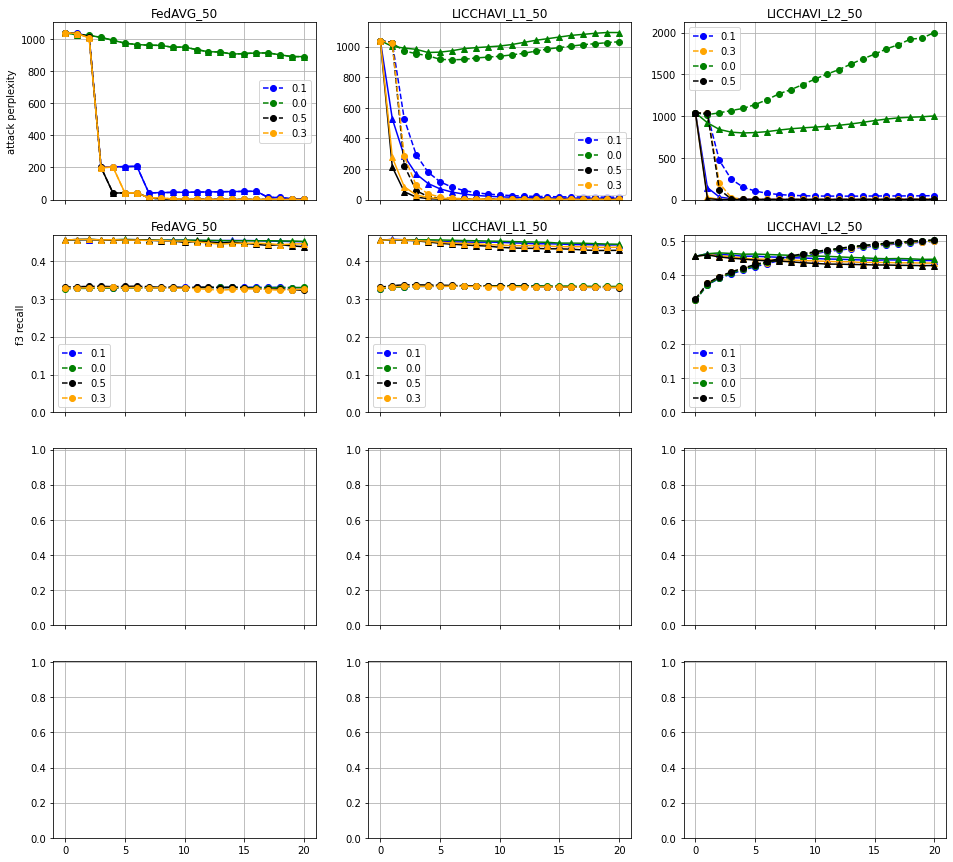

In [131]:
plot_attack('data_poisoning', 'tweets')

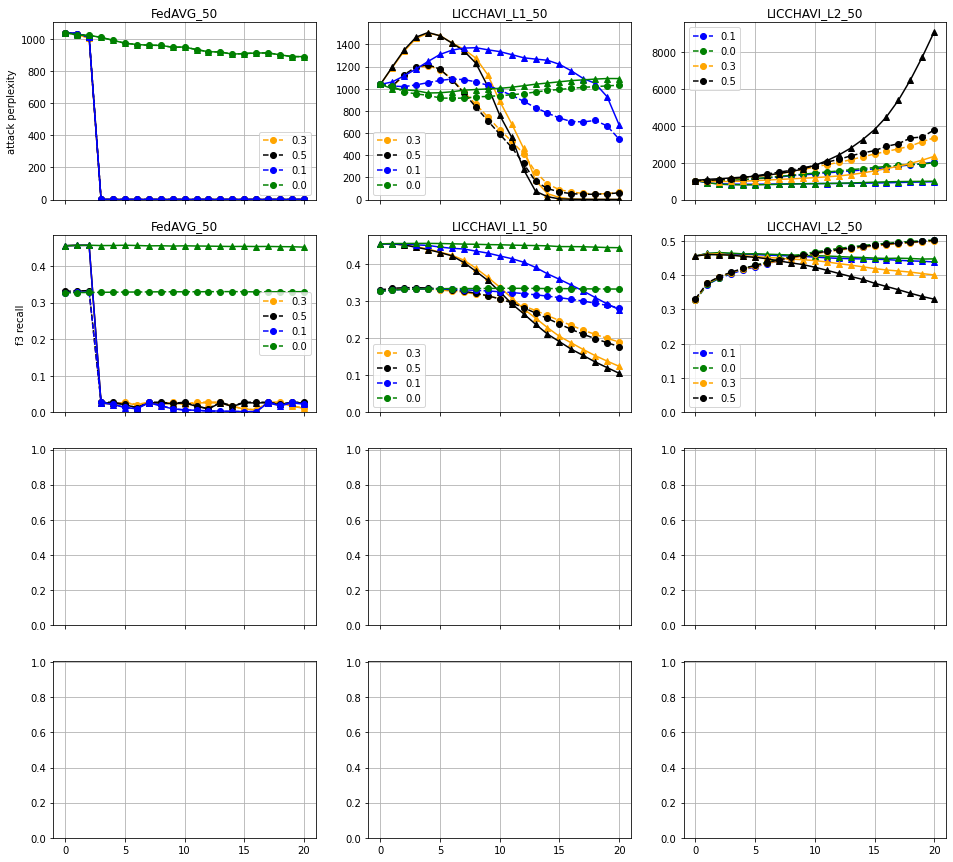

In [132]:
plot_attack('model_forging', 'tweets')